In [32]:
import pandas as pd
from ast import literal_eval
from decimal import Decimal
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Loader():
    def strToDecArr(self, str):
        # this version is slower and potentially insecure because of the eval function
        # return np.array([eval(x) for x in str[1:-1].split(', ')])
        return np.asarray([Decimal(x.split("'")[1]) for x in str[1:-1].split(', ')])

    def load_snapshots(self, filepath):
        return pd.read_csv(filepath,
                           converters={"ask_prices": self.strToDecArr, "ask_amounts": self.strToDecArr,
                                       "bid_prices": self.strToDecArr, "bid_amounts": self.strToDecArr,
                                       "date": pd.to_datetime})

    def load_trades(self, filepath):
        return pd.read_csv(filepath, converters={"date": pd.to_datetime})

In [3]:
loader = Loader()
snapshots = loader.load_snapshots(
    "/Users/Fanda/Documents/TUM_Offline/HF_Data-15.10.2021/snapshots_btc-usdt_20211015.csv")
trades = loader.load_trades(
    "/Users/Fanda/Documents/TUM_Offline/HF_Data-15.10.2021/trades_btc-usdt_20211015.csv")

In [6]:
snapshots["midprice"] = snapshots.apply(lambda x: (np.min(x.loc["ask_prices"]) + np.max(x.loc["bid_prices"])) / 2,
                                        axis = 1)

In [19]:
def orderbook_imbalance(x):
    total_bid_volume = np.sum(x.loc["bid_amounts"])
    total_ask_volume = np.sum(x.loc["ask_amounts"])
    return ((total_bid_volume - total_ask_volume) / (total_bid_volume + total_ask_volume))
snapshots["orderbook_imbalance"] = snapshots.apply(orderbook_imbalance, axis = 1)

In [20]:
minute_snapshots = snapshots.resample('min', on='date').agg({'midprice':'mean', 'orderbook_imbalance':'mean'})

In [21]:
def agg(x):
    names = {
        'open': x['price'].head(1).item(),
        'high':  x['price'].max(),
        'low': x['price'].min(),
        'close':  x['price'].tail(1).item(),
        'volume_base': x['amount'].sum(),
        'volume_quote': (x['amount'] * x['price']).sum()}

    return pd.Series(names)
minute_trades = trades.resample('min', on='date').apply(agg)

In [22]:
close_rolling = minute_trades["close"].rolling(60).mean()
orderbook_imbalance_rolling = minute_snapshots["orderbook_imbalance"].rolling(60).mean()

<AxesSubplot:xlabel='date'>

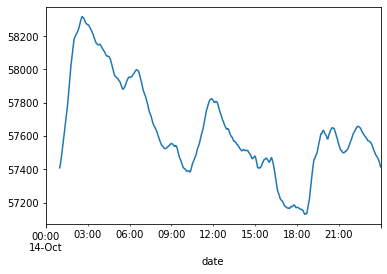

In [23]:
close_rolling.plot()

<AxesSubplot:xlabel='date'>

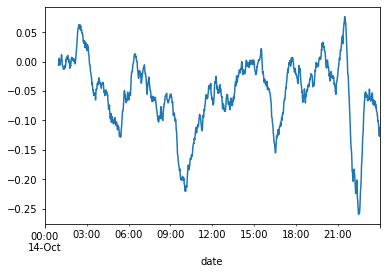

In [24]:
orderbook_imbalance_rolling.plot()

We can observe that most of the time there is a sell order imbalance - which means that there are more sell orders in volume than buy orders. The orderbook imbalance graph correlates with the close price graph. We can observe that when the price was going up people were more buying when it was going down more selling.

In [26]:
def getTradeExamples(volumes, sell):
    new_trades = trades.loc[trades["buyer_maker"] == sell]
    return [new_trades.iloc[(new_trades['amount'] * new_trades["price"] - v).abs().argsort().head(1).item()]
            for v in volumes]
        
volumes = [1000, 10000, 50000, 100000, 1000000]
impact_trades_buy = getTradeExamples(volumes, False)
impact_trades_sell = getTradeExamples(volumes, True)

In [27]:
def calculateImpact(impact_trade):
    ideal_cost = snapshots.loc[impact_trade.date <= snapshots["date"]].head(1).midprice.item()
    actual_cost = Decimal(impact_trade.price)
    impact = (actual_cost - ideal_cost)/ideal_cost * 100
    return impact
buy_impacts = [calculateImpact(t) for t in impact_trades_buy]
sell_impacts = [calculateImpact(t) for t in impact_trades_sell]

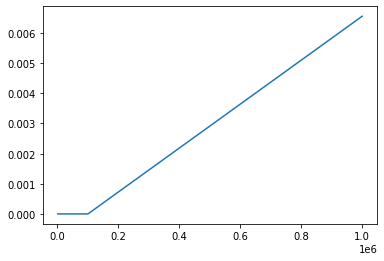

In [35]:
plt.plot(volumes, buy_impacts)

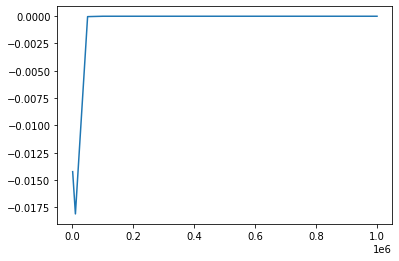

In [37]:
plt.plot(volumes, sell_impacts)

We can see that the impact is rising with bigger amounts. This is logical since trades for bigger volumes consist of multiple orders. Those trades can only include orders the same or more distant from the ideal price and therefore have higher impact cost.